In [21]:
import os
from datetime import datetime
# import shutil
from glob import glob
import rioxarray as rxr
from rioxarray.exceptions import NoDataInBounds
import rasterio.features
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from tqdm import tqdm
import matplotlib.pyplot as plt
from rasterio.errors import NotGeoreferencedWarning
import warnings
import torch
import pandas as pd
import pickle
import cv2
from multiprocessing import Pool
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
np.seterr(divide='ignore', invalid='ignore')
from util import recreate_dir, load_config
from p_tqdm import p_map


In [22]:
DATA_DIR = "data/20221220_sudol_krakow"
CFG = load_config(f"{DATA_DIR}/config.py").CALIBRATION

In [23]:
#configure logging to file
import logging
log_path = f"{DATA_DIR}/logs/calibration_{datetime.now().strftime('%d%m%Y%H%M%S')}.log"
os.makedirs(os.path.dirname(log_path), exist_ok=True)
logging.basicConfig(filename=log_path,level=logging.INFO, format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)
logger.handlers.clear()
#logger.addHandler(logging.StreamHandler())
logger.info("Starting procedure")

In [24]:
TMP_DIR = f"{DATA_DIR}/tmp"
recreate_dir(TMP_DIR)
TIF_DEVIGNETTE_DIR = f"{DATA_DIR}/tif_devignette"
assert os.path.exists(TIF_DEVIGNETTE_DIR), "TIF_DEVIGNETT_DIR does not exist. Please run 2_devignetting.ipynb first."
GEOTIF_DEVIGNETTE_DIR = f"{DATA_DIR}/geotif_devignette"
assert os.path.exists(GEOTIF_DEVIGNETTE_DIR), "GEOTIF_DEVIGNETT_DIR does not exist. Please run 2_devignetting.ipynb first."

TIF_CAL_DIR = f"{DATA_DIR}/tif_cal"
GEOTIF_CAL_DIR = f"{DATA_DIR}/geotif_cal"

# PLOT_CLIP_DIR = f"{DATA_DIR}/plot_clip"
# PLOT_CAL_DIR = f"{DATA_DIR}/plot_cal"
CACHE_DIR = f"{DATA_DIR}/cache"
os.makedirs(CACHE_DIR, exist_ok=True)
# TEMP_OPTIM_DATASET_DIR = f"{DATA_DIR}/temp_optim_dataset"
# I_CLIP_DIR = f"{TEMP_OPTIM_DATASET_DIR}/i_clip"
# J_CLIP_DIR = f"{TEMP_OPTIM_DATASET_DIR}/j_clip"
# CLIP_MASK_DIR = f"{TEMP_OPTIM_DATASET_DIR}/clip_mask"

In [25]:
# if CFG.CACHE and os.path.exists(f"{CACHE_DIR}/footprints.pkl"):
#     logger.info("Loading footprints from cache")
#     with open(f"{CACHE_DIR}/footprints.pkl", "rb") as f:
#         footprints = pickle.load(f)
# else:
logger.info("Reading footprints from geotifs")
geometries = []
names = []
timestamps = []
def get_footprint(path):
    raster = rxr.open_rasterio(path)
    mean_val = raster.where(raster != raster.rio.nodata).mean().values.item()
    footprints = rasterio.features.shapes((raster != raster.rio.nodata).values.astype(np.int16), transform=raster.rio.transform())
    footprints = [Polygon(geom["coordinates"][0]).simplify(10) for geom, colval in footprints if colval == 1]
    assert len(footprints) == 1, "More than one footprint found"
    name = os.path.basename(path)
    return name, footprints[0], mean_val
#use p_map
names, geometries, mean_vals = zip(*p_map(get_footprint, glob(f"{GEOTIF_DEVIGNETTE_DIR}/*.tif")))

footprints = gpd.GeoDataFrame({"name": names, "geometry": geometries, "mean": mean_vals})
#write CRS
footprints.crs = CFG.CRS
# with open(f"{CACHE_DIR}/footprints.pkl", "wb") as f:
#     pickle.dump(footprints, f)

  0%|          | 0/391 [00:00<?, ?it/s]

In [26]:

if CFG.CACHE and os.path.exists(f"{CACHE_DIR}/calibration_pairs.pkl"):
    logger.info("Loading cached pairs")
    with open(f"{CACHE_DIR}/calibration_pairs.pkl", "rb") as f:
        pairs_i, pairs_j, pairs_area, i_clips, j_clips, masks, diff_vars, i_means, j_means = pickle.load(f)
else:
    logger.info("Generating temprature global optimization dataset")
    #erode footprints
    if CFG.EROSION > 0:
        footprints["geometry"] = footprints["geometry"].buffer(-CFG.EROSION)
    # recreate_dir(TEMP_OPTIM_DATASET_DIR)
    # recreate_dir(I_CLIP_DIR)
    # recreate_dir(J_CLIP_DIR)
    # recreate_dir(CLIP_MASK_DIR)
    # recreate_dir(PLOT_CLIP_DIR)

    def get_dataset(i):
        pairs_i = []
        pairs_j = []
        pairs_area = []
        i_clips = []
        j_clips = []
        masks = []
        diff_vars = []
        i_means = []
        j_means = []
        i_raster = rxr.open_rasterio(f"{GEOTIF_DEVIGNETTE_DIR}/{footprints.iloc[i]['name']}", masked=True)
        for j in range(i+1, len(footprints)):
            if not footprints.iloc[i].geometry.intersects(footprints.iloc[j].geometry):
                continue
            intersection = footprints.iloc[i].geometry.intersection(footprints.iloc[j].geometry)
            if intersection.area < CFG.MIN_INTERSECTION_AREA:
                logger.info(f"i ({i}), j ({j}): intersection area too small")
                continue
            j_raster = rxr.open_rasterio(f"{GEOTIF_DEVIGNETTE_DIR}/{footprints.iloc[j]['name']}", masked=True)
            try:
                i_clip = i_raster.rio.clip([intersection])
                j_clip = j_raster.rio.clip([intersection])
            except NoDataInBounds:
                logger.info(f"i ({i}), j ({j}): NoDataInBounds")
                continue
            j_clip = j_clip.rio.reproject_match(i_clip)
            i_clip = i_clip.values[0]
            j_clip = j_clip.values[0]
            i_mean = np.nanmean(i_clip)
            j_mean = np.nanmean(j_clip)
            diff = i_clip - j_clip
            #variance of difference
            diff_var = np.nanvar(diff)
            mask = (~np.isnan(i_clip) & ~np.isnan(j_clip)).astype(np.int16)
            i_clip[np.isnan(i_clip)] = np.nanmean(i_clip)
            j_clip[np.isnan(j_clip)] = np.nanmean(j_clip)

            i_clip = cv2.resize(i_clip, (CFG.CLIP_SIZE, CFG.CLIP_SIZE), interpolation=cv2.INTER_LINEAR)
            j_clip = cv2.resize(j_clip, (CFG.CLIP_SIZE, CFG.CLIP_SIZE), interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, (CFG.CLIP_SIZE, CFG.CLIP_SIZE), interpolation=cv2.INTER_NEAREST)
            #assert i_clip, j_clip, mask dont have nans
            if np.isnan(i_clip).any():
                logger.info(f"i ({i}), j ({j}): i_clip has nan")
                continue
            if np.isnan(j_clip).any():
                logger.info(f"i ({i}), j ({j}): j_clip has nan")
                continue
            if np.isnan(mask).any():
                logger.info(f"i ({i}), j ({j}): mask has nan")
                continue
            pairs_i.append(i)
            pairs_j.append(j)
            pairs_area.append(intersection.area)
            i_clips.append(i_clip)
            j_clips.append(j_clip)
            masks.append(mask)
            diff_vars.append(diff_var)
            i_means.append(i_mean)
            j_means.append(j_mean)
            
        return pairs_i, pairs_j, pairs_area, i_clips, j_clips, masks, diff_vars, i_means, j_means
    #use p_map
    pairs_i, pairs_j, pairs_area, i_clips, j_clips, masks, diff_vars, i_means, j_means = zip(*p_map(get_dataset, range(len(footprints))))

    #concatenate pairs
    pairs_i = [item for sublist in pairs_i for item in sublist]
    pairs_j = [item for sublist in pairs_j for item in sublist]
    pairs_area = [item for sublist in pairs_area for item in sublist]
    i_clips = [item for sublist in i_clips for item in sublist]
    j_clips = [item for sublist in j_clips for item in sublist]
    masks = [item for sublist in masks for item in sublist]
    diff_vars = [item for sublist in diff_vars for item in sublist]
    i_means = [item for sublist in i_means for item in sublist]
    j_means = [item for sublist in j_means for item in sublist]
    
    #remove empty lists
    # pairs_i = [_ for _ in pairs_i if len(_) > 0]
    # pairs_j = [_ for _ in pairs_j if len(_) > 0]
    # pairs_area = [_ for _ in pairs_area if len(_) > 0]
    # i_clips = [_ for _ in i_clips if len(_) > 0]
    # j_clips = [_ for _ in j_clips if len(_) > 0]
    # masks = [_ for _ in masks if len(_) > 0]
    # diff_vars = [_ for _ in diff_vars if len(_) > 0]
    # i_means = [_ for _ in i_means if len(_) > 0]
    # j_means = [_ for _ in j_means if len(_) > 0]

    # pairs_i = np.concatenate(pairs_i)
    # pairs_j = np.concatenate(pairs_j)
    # pairs_area = np.concatenate(pairs_area)
    # i_clips = np.concatenate(i_clips)
    # j_clips = np.concatenate(j_clips)
    # masks = np.concatenate(masks)
    # diff_vars = np.concatenate(diff_vars)
    # i_means = np.concatenate(i_means)
    # j_means = np.concatenate(j_means)

    assert len(pairs_i) == len(pairs_j) == len(pairs_area) == len(i_clips) == len(j_clips) == len(masks) == len(diff_vars) == len(i_means) == len(j_means), "Lengths do not match"
    
    with open(f"{CACHE_DIR}/calibration_pairs.pkl", "wb") as f:
        pickle.dump((pairs_i, pairs_j, pairs_area, i_clips, j_clips, masks, diff_vars, i_means, j_means), f)

  0%|          | 0/391 [00:00<?, ?it/s]

In [27]:
area_weights = np.array(pairs_area)#np.emath.logn(10, pairs_area)
#normalize from 0 to 1
area_weights = area_weights/area_weights.max()#(area_weights - areights.min()) / (area_weights.max() - area_weights.min())
#var_weights = np.emath.logn(10, 1/diff_vars)
#var_weights = (var_weights - var_weights.min()) / (var_weights.max() - var_weights.min())
#weights = area_weights * var_weights
weights = area_weights

In [28]:
#recreate_dir(PLOT_CLIP_DIR)

n_images = len(footprints)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_i = torch.tensor(pairs_i, dtype=torch.int64, device=device) # (n_pairs,)
pairs_j = torch.tensor(pairs_j, dtype=torch.int64, device=device) # (n_pairs,)
i_means = torch.tensor(i_means, dtype=torch.float32, device=device) # (n_pairs,)
j_means = torch.tensor(j_means, dtype=torch.float32, device=device) # (n_pairs,)
image_means = torch.tensor(footprints["mean"].values, dtype=torch.float32, device=device) # (n_images,)
pairs_area = torch.tensor(pairs_area, dtype=torch.float32, device=device) # (n_pairs,)
#pairs_var = torch.tensor(pairs_var, dtype=torch.float32, device=device) # (n_pairs,)
i_clips = torch.tensor(i_clips, dtype=torch.float32, device=device) # (n_pairs, width, height)
j_clips = torch.tensor(j_clips, dtype=torch.float32, device=device) # (n_pairs, width, height)
masks = torch.tensor(masks, dtype=torch.float32, device=device) # (n_pairs, width, height)
weights = torch.tensor(weights, dtype=torch.float32, device=device) # (n_pairs,)
pairs_n_pixels = torch.sum(masks, dim=(1, 2)) # (n_pairs,)
n_pixels = torch.sum(pairs_n_pixels) # (1,)
#n_pixels_weighted = torch.sum(pairs_n_pixels * weights) # (1,)
n_pairs = len(pairs_i) # (1,)

i_clips_mean = torch.sum(i_clips * masks, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
j_clips_mean = torch.sum(j_clips * masks, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
i_clips_var = torch.sum(masks * (i_clips - i_clips_mean[:, None, None]) ** 2, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
j_clips_var = torch.sum(masks * (j_clips - j_clips_mean[:, None, None]) ** 2, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
a_coefs = torch.ones(n_images, dtype=torch.float32, device=device, requires_grad=False) # (n_images,)
b_coefs = torch.zeros(n_images, dtype=torch.float32, device=device, requires_grad=True) # (n_images,)

optimizer = torch.optim.Adam([b_coefs], lr=CFG.INIT_LR)#([a_coefs, b_coefs], lr=CFG.INIT_LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=CFG.LR_PLATEAU_FACTOR, patience=CFG.LR_PLATEAU_PATIENCE, cooldown=CFG.LR_PLATEAU_COOLDOWN, threshold=CFG.LR_PLATEAU_THRESHOLD, verbose=True)
pairs_i_copy = pairs_i.clone()
pairs_j_copy = pairs_j.clone()
best_loss = np.inf
es_counter = 0
pixel_losses = []
mean_losses = []
var_losses = []
bias_losses = []
for epoch in (pbar := tqdm(range(CFG.EPOCHS))):
    #assert that pairs_i and pairs_j are equal to the original values
    assert torch.all(pairs_i == pairs_i_copy)
    assert torch.all(pairs_j == pairs_j_copy)
    pbar.set_description(f"Epoch {epoch}")
    optimizer.zero_grad()
    i_clips_cal = a_coefs[pairs_i, None, None] * i_clips + b_coefs[pairs_i, None, None] # (n_pairs, width, height)
    j_clips_cal = a_coefs[pairs_j, None, None] * j_clips + b_coefs[pairs_j, None, None] # (n_pairs, width, height)
    image_means_cal = a_coefs * image_means + b_coefs # (n_images,)
    # i_clips_cal_mean = torch.sum(i_clips_cal * masks, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
    # j_clips_cal_mean = torch.sum(j_clips_cal * masks, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
    # i_clips_cal_var = torch.sum(masks * (i_clips_cal - i_clips_cal_mean[:, None, None]) ** 2, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
    # j_clips_cal_var = torch.sum(masks * (j_clips_cal - j_clips_cal_mean[:, None, None]) ** 2, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
    i_means_cal = a_coefs[pairs_i] * i_means + b_coefs[pairs_i] # (n_pairs,)
    j_means_cal = a_coefs[pairs_j] * j_means + b_coefs[pairs_j] # (n_pairs,)
    #assert that i_clips_cal_mean and j_clips_cal_mean do not contain any NaNs

    # #group i_clips_cal_mean by pairs_i and calculate the mean
    # if epoch % 50 == 0:
    #     xs = []
    #     ys = []
    #     for k in range(n_images):
    #         for mean_val in i_clips_cal_mean.detach().cpu().numpy()[pairs_i == k]:
    #             xs.append(k)
    #             ys.append(mean_val)
    #         for mean_val in j_clips_cal_mean.detach().cpu().numpy()[pairs_j == k]:
    #             xs.append(k)
    #             ys.append(mean_val)
    #     plt.plot(xs, ys, ".")
    #     plt.show()
    #####
    pixel_loss = torch.sum((i_clips_cal - j_clips_cal)**2 * masks * weights[:, None, None])/n_pixels
    #pixel_loss = torch.sum((i_means_cal - j_means_cal)**2 * weights)/n_pairs
    #####
    #loss using image means and image means cal
    # pixel_loss = torch.sum((image_means_cal - image_means)**2)/n_images
    ##
    
    #pixel_loss = torch.mean((i_clips_cal_mean - j_clips_cal_mean)**2)
    # mean_loss = 0.0000001  *(0.5/n_pairs)*(
    #                 torch.sum((i_clips_cal_mean - i_clips_mean)**2 * weights[:, None, None]) + 
    #                 torch.sum((j_clips_cal_mean - j_clips_mean)**2 * weights[:, None, None])
    #             )
    mean_loss = 0.01*torch.abs(torch.mean(image_means_cal) - torch.mean(image_means))
    #var_loss =  0.1   *(0.5/n_pairs)*(torch.sum(torch.abs(i_clips_cal_var - i_clips_var)**1)   + torch.sum(torch.abs(j_clips_cal_var - j_clips_var)**1))

    loss = pixel_loss + mean_loss# + var_loss
    # loss = bias_loss
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    if best_loss-loss.item() > CFG.ES_MIN_DELTA:
        best_loss = loss.item()
        best_a_coefs = a_coefs.detach().cpu().numpy()
        best_b_coefs = b_coefs.detach().cpu().numpy()
        es_counter = 0
    else:
        es_counter += 1
        if es_counter > CFG.ES_PATIENCE:
            print("Early stopping")
            # for i_clip, j_clip, i, j, mask, a_i, b_i, a_j, b_j, i_clip_cal_mean, j_clip_cal_mean in zip(tqdm(i_clips_cal.detach().cpu().numpy()), j_clips_cal.detach().cpu().numpy(), pairs_i.detach().cpu().numpy(), pairs_j.detach().cpu().numpy(), masks.detach().cpu().numpy(), a_coefs[pairs_i].detach().cpu().numpy(), b_coefs[pairs_i].detach().cpu().numpy(), a_coefs[pairs_j].detach().cpu().numpy(), b_coefs[pairs_j].detach().cpu().numpy(), i_clips_cal_mean.detach().cpu().numpy(), j_clips_cal_mean.detach().cpu().numpy()):
            #     fig, ax = plt.subplots(1,2, dpi=50)
            #     ax[0].imshow(i_clip * mask)
            #     ax[0].set_title(f"{i} {i_clip_cal_mean}")
            #     ax[1].imshow(j_clip * mask)
            #     ax[1].set_title(f"{j} {j_clip_cal_mean}")
            #     fig.savefig(f"{PLOT_CLIP_DIR}/{i}_{j}.png")
            #     plt.close(fig)
            break
    # bias_losses.append(bias_loss.item())
    pixel_losses.append(pixel_loss.item())
    mean_losses.append(mean_loss.item())
    #var_losses.append(var_loss.item())

    pbar.set_postfix({
        "pixel_loss": pixel_loss.item(), 
        # 'bias_loss': bias_loss.item(),
        "mean_loss": mean_loss.item(),
        #"var_loss": var_loss.item(),
        "loss": loss.item(), 
        "a_mean": a_coefs.mean().item(), 
        "b_mean": b_coefs.mean().item()})

Epoch 367:   4%|▎         | 366/10000 [00:26<10:44, 14.95it/s, pixel_loss=0.147, mean_loss=1.31e-5, loss=0.147, a_mean=1, b_mean=-.000616]

Epoch 00365: reducing learning rate of group 0 to 1.0000e-02.


Epoch 453:   5%|▍         | 452/10000 [00:32<11:46, 13.51it/s, pixel_loss=0.147, mean_loss=4.34e-6, loss=0.147, a_mean=1, b_mean=0.000394]

Epoch 00451: reducing learning rate of group 0 to 1.0000e-03.


Epoch 492:   5%|▍         | 492/10000 [00:35<11:24, 13.89it/s, pixel_loss=0.147, mean_loss=4.7e-7, loss=0.147, a_mean=1, b_mean=-2.83e-6] 

Early stopping


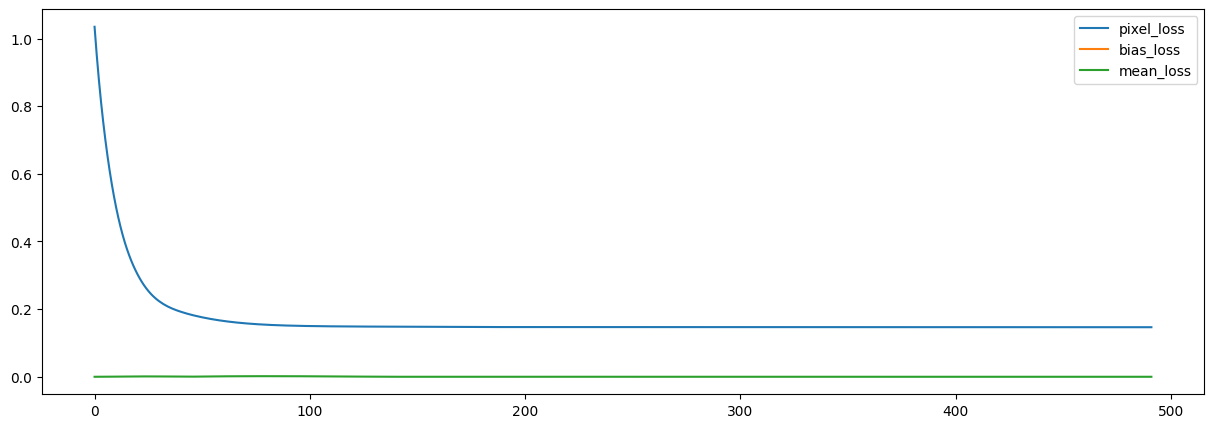

In [29]:
#plot losses with log scale
plt.figure(figsize=(15, 5))
plt.plot(pixel_losses, label="pixel_loss")
plt.plot(bias_losses, label="bias_loss")
plt.plot(mean_losses, label="mean_loss")
#plt.plot(var_losses, label="var_loss")
#plt.yscale("log")
plt.legend()
plt.show()

In [30]:

recreate_dir(GEOTIF_CAL_DIR)
recreate_dir(TIF_CAL_DIR)
def save_calib(name, a, b):
    geotif = rxr.open_rasterio(f"{GEOTIF_DEVIGNETTE_DIR}/{name}", masked=True)
    geotif.data = geotif.data * a + b
    geotif.rio.to_raster(f"{GEOTIF_CAL_DIR}/{name}")
    tif = rxr.open_rasterio(f"{TIF_DEVIGNETTE_DIR}/{name}", masked=True)
    tif.data = tif.data * a + b
    tif.rio.to_raster(f"{TIF_CAL_DIR}/{name}")
resutlts = p_map(save_calib, footprints["name"], best_a_coefs, best_b_coefs)

  0%|          | 0/391 [00:00<?, ?it/s]